In [74]:
import pandas as pd
import numpy as np
import seaborn as sns

import glob
import os

os.chdir('../data/')
all_data_available = glob.glob('*.csv')
print(all_data_available)

['04-07_carbonhealth_and_braidhealth.csv', '04-14_carbonhealth_and_braidhealth.csv', '04-21_carbonhealth_and_braidhealth.csv', '04-28_carbonhealth_and_braidhealth.csv', '05-05_carbonhealth_and_braidhealth.csv', '05-12_carbonhealth_and_braidhealth.csv', '05-19_carbonhealth_and_braidhealth.csv', '05-26_carbonhealth_and_braidhealth.csv', '06-02_carbonhealth_and_braidhealth.csv', '06-09_carbonhealth_and_braidhealth.csv', '06-16_carbonhealth_and_braidhealth.csv', '06-23_carbonhealth_and_braidhealth.csv', '06-30_carbonhealth_and_braidhealth.csv', '07-07_carbonhealth_and_braidhealth.csv', '07-14_carbonhealth_and_braidhealth.csv', '07-21_carbonhealth_and_braidhealth.csv', '07-28_carbonhealth_and_braidhealth.csv', '08-04_carbonhealth_and_braidhealth.csv', '08-11_carbonhealth_and_braidhealth.csv', '08-18_carbonhealth_and_braidhealth.csv', '08-25_carbonhealth_and_braidhealth.csv', '09-01_carbonhealth_and_braidhealth.csv', '09-08_carbonhealth_and_braidhealth.csv', '09-15_carbonhealth_and_braidheal

In [90]:
all_data = pd.read_csv("../data/04-14_carbonhealth_and_braidhealth.csv")
for file in all_data_available:      
    if file != "04-14_carbonhealth_and_braidhealth.csv":
        try:
            df = pd.read_csv("../data/" + file)
            print(file, df["covid19_test_results"].value_counts()["Positive"] / len(df["covid19_test_results"]))
            all_data = pd.merge(all_data, df, how="outer")
            print("All data size:", len(all_data))
        except:
            print(file, "could not be merged")
df.info()

04-07_carbonhealth_and_braidhealth.csv 0.061224489795918366
All data size: 998
04-21_carbonhealth_and_braidhealth.csv 0.03074141048824593
All data size: 2104
04-28_carbonhealth_and_braidhealth.csv 0.011996572407883462
All data size: 3271
05-05_carbonhealth_and_braidhealth.csv 0.018738288569643973
All data size: 4872
05-12_carbonhealth_and_braidhealth.csv 0.03541315345699832
All data size: 5465
05-19_carbonhealth_and_braidhealth.csv 0.05353319057815846
All data size: 6399
05-26_carbonhealth_and_braidhealth.csv 0.04533333333333334
All data size: 7149
06-02_carbonhealth_and_braidhealth.csv 0.03134479271991911
All data size: 8138
06-09_carbonhealth_and_braidhealth.csv 0.010725552050473186
All data size: 9723
06-16_carbonhealth_and_braidhealth.csv 0.011756569847856155
All data size: 11169
06-23_carbonhealth_and_braidhealth.csv 0.020618556701030927
All data size: 13594
06-30_carbonhealth_and_braidhealth.csv 0.03353204172876304
All data size: 16278
07-07_carbonhealth_and_braidhealth.csv 0.042

In [94]:
all_data.drop(columns=["batch_date", "rapid_flu_results", "rapid_strep_results"], inplace=True)

KeyError: "['batch_date' 'rapid_flu_results' 'rapid_strep_results'] not found in axis"

In [95]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86547 entries, 0 to 86546
Data columns (total 43 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   test_name                      86547 non-null  object 
 1   swab_type                      86547 non-null  object 
 2   covid19_test_results           86547 non-null  object 
 3   age                            86547 non-null  int64  
 4   high_risk_exposure_occupation  86378 non-null  object 
 5   high_risk_interactions         62163 non-null  object 
 6   diabetes                       86547 non-null  object 
 7   chd                            86547 non-null  object 
 8   htn                            86547 non-null  object 
 9   cancer                         86547 non-null  object 
 10  asthma                         86547 non-null  object 
 11  copd                           86547 non-null  object 
 12  autoimmune_dis                 86547 non-null 

In [97]:
#Lets see how many unique values each column has
for column in all_data.columns:
    print(column, len(all_data[column].unique()), sep=": ")

test_name: 11
swab_type: 19
covid19_test_results: 2
age: 95
high_risk_exposure_occupation: 3
high_risk_interactions: 3
diabetes: 2
chd: 2
htn: 2
cancer: 2
asthma: 2
copd: 2
autoimmune_dis: 2
smoker: 2
temperature: 87
pulse: 113
sys: 104
dia: 92
rr: 29
sats: 21
ctab: 3
labored_respiration: 3
rhonchi: 3
wheezes: 3
days_since_symptom_onset: 21
cough: 3
cough_severity: 4
fever: 3
sob: 3
sob_severity: 4
diarrhea: 3
fatigue: 3
headache: 3
loss_of_smell: 3
loss_of_taste: 3
runny_nose: 3
muscle_sore: 3
sore_throat: 3
cxr_findings: 295
cxr_impression: 245
cxr_label: 4
cxr_link: 669
er_referral: 2


In [100]:
all_data["covid19_test_results"].value_counts()["Positive"] / len(df["covid19_test_results"])

0.1689059500959693

In [102]:
all_data[all_data["covid19_test_results"] == "Negative"].iloc[:,14:24].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85315 entries, 0 to 86546
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   temperature          42494 non-null  float64
 1   pulse                42981 non-null  float64
 2   sys                  41422 non-null  float64
 3   dia                  41422 non-null  float64
 4   rr                   36823 non-null  float64
 5   sats                 42260 non-null  float64
 6   ctab                 31811 non-null  object 
 7   labored_respiration  43338 non-null  object 
 8   rhonchi              20972 non-null  object 
 9   wheezes              24613 non-null  object 
dtypes: float64(6), object(4)
memory usage: 7.2+ MB


C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age', ylabel='Density'>

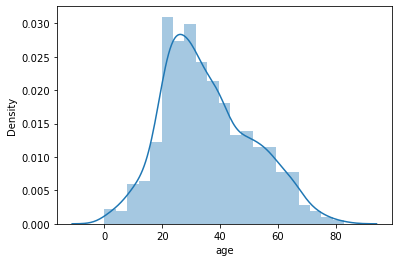

In [109]:
sns.distplot(all_data[all_data["covid19_test_results"] == "Positive"]["age"])
sns.distplot(all_data[all_data["covid19_test_results"] == "Negative"]["age"])

C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age', ylabel='Density'>

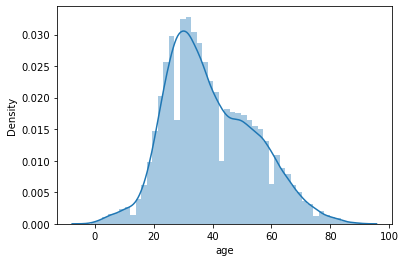

In [110]:
sns.distplot(all_data[all_data["covid19_test_results"] == "Negative"]["age"])